## Lab 10: Diabatically Driven IPV Changes
In our final lab of the semester, we will generate IPV maps to diagnose the tropical transition of an initially extratropical (or non-tropical midlatitude) cyclone.

<br />


### Useful Documentation
1. Xarray open_dataset:  https://docs.xarray.dev/en/stable/generated/xarray.open_dataset.html
2. Matplotlib Contour: https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.contour.html
3. Cartopy Feature: https://scitools.org.uk/cartopy/docs/latest/matplotlib/feature_interface.html
4. MetPy Units: https://unidata.github.io/MetPy/latest/tutorials/unit_tutorial.html
5. Datetime: https://docs.python.org/3/library/datetime.html
6. Scipy gaussian_filter: https://docs.scipy.org/doc/scipy/reference/generated/scipy.ndimage.gaussian_filter.html
7. MetPy isentropic_interpolation_as_dataset: https://unidata.github.io/MetPy/latest/api/generated/metpy.calc.isentropic_interpolation_as_dataset.html#metpy.calc.isentropic_interpolation_as_dataset
8. MetPy potential_temperature: https://unidata.github.io/MetPy/latest/api/generated/metpy.calc.potential_temperature.html
9. MetPy potential_vorticity_baroclinic: https://unidata.github.io/MetPy/latest/api/generated/metpy.calc.potential_vorticity_baroclinic.html

<br />

## Tutorial

In this week's lab, we will use ERA5 reanalysis data rather than GFS data to examine a case from 2012.  Reanalysis data such as ERA5 are generated retrospectively using a numerical model (in this case, the ECMWF model), archived observations, and data assimilation.  In contrast to a model analysis, a reanalysis typically incorporates more observations and a newer (hopefully improved!) model version.

Although ERA5 is a gridded dataset, its gridding structure differs from that of GFS data, with a different file type (for the provided data; ERA5 data are also available in GRIB format, like with the GFS) and different variable names.  The former is not a major issue, however, since xarray opens netCDF files similarly to GRIB files so long as we change the decoding engine used by xarray to open the file.  

<br />

As a aside, you can use the link below to download ERA5 data for any available case. For this lab, however, I have already downloaded the data for you.

<br />

https://cds.climate.copernicus.eu/cdsapp#!/dataset/reanalysis-era5-pressure-levels?tab=form

<br />

In the cell below, I demonstrate how to open ERA5 data for June 18th, 2012 at 1200 UTC.

In [1]:
from datetime import datetime
import xarray as xr

time = datetime(2012,6,18,12)
data_location = "/data/AtmSci360/Synp2/Lab_10/"
file_name = f"{time:%m%d%Y_%H%M}_ERA5.nc"

# note the different engine passed to xarray
data = xr.open_dataset(f"{data_location}{file_name}", engine='netcdf4')
data

<xarray.Dataset>
Dimensions:    (longitude: 361, latitude: 241, level: 37, time: 1)
Coordinates:
  * longitude  (longitude) float32 -100.0 -99.75 -99.5 ... -10.5 -10.25 -10.0
  * latitude   (latitude) float32 70.0 69.75 69.5 69.25 ... 10.5 10.25 10.0
  * level      (level) int32 1 2 3 5 7 10 20 30 ... 850 875 900 925 950 975 1000
  * time       (time) datetime64[ns] 2012-06-18T12:00:00
Data variables:
    t          (time, level, latitude, longitude) float32 ...
    u          (time, level, latitude, longitude) float32 ...
    v          (time, level, latitude, longitude) float32 ...
Attributes:
    Conventions:  CF-1.6
    history:      2023-04-11 21:13:24 GMT by grib_to_netcdf-2.25.1: /opt/ecmw...

### Instructions
So that you can complete this week's lab, I have locally archived the June 17th, 2012 1200 UTC and June 18th, 2012 0000 UTC ERA5 analyses.  The location of these datasets are provided for you below, as is the filename convention if you wish to use a datetime object to select your time of interest.

<br />

Using these data, create 330-K potential vorticity (PVU) and horizontal wind (kt) maps for 1200 UTC June 17th, 2012 and 0000 UTC June 18th, 2012.  You may find it helpful to refer to Lab 8's code when preparing these maps.  Be sure your maps follow the "good map" guidelines, and do not forget to import the necessary packages before you start coding.  

In [2]:
from datetime import datetime
from metpy.io import add_station_lat_lon
from metpy.plots import StationPlot, sky_cover
import numpy as np
import cartopy.crs as crs 
import cartopy
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter
import xarray as xr
import sys
from metpy.units import units
import metpy.calc as calc
import pandas as pd

In [3]:
def process_K_air_data(time):
    data_location = "/data/AtmSci360/Synp2/Lab_10/"

    file_name = f"{time:%m%d%Y_%H%M}_ERA5.nc"
  
    model_data = xr.open_dataset(f"{data_location}{file_name}", engine='netcdf4')
    levels = [325,330,335] * units.kelvin
    model_data= model_data.sel(time=time)
    Kdata=calc.isentropic_interpolation_as_dataset(levels, model_data.t, model_data.u, model_data.v)
    return Kdata

In [4]:
'''
data_location = "/data/AtmSci360/Synp2/Lab_10/"
file_name = f"{time:%m%d%Y_%H%M}_ERA5.nc"
'''

'\ndata_location = "/data/AtmSci360/Synp2/Lab_10/"\nfile_name = f"{time:%m%d%Y_%H%M}_ERA5.nc"\n'

In [5]:
def plot_330K(time, Kdata):
    model_data=Kdata
    proj = crs.LambertConformal(central_longitude=-95, central_latitude=35, standard_parallels=[27.5,42.5])
    
 
    fig = plt.figure(figsize=(11.5,7),dpi=300)
    ax=plt.subplot(projection = proj)

    
    ax.add_feature(cfeature.LAND.with_scale('50m'), edgecolor = "black", facecolor='none',  linewidth=0.75, zorder=2)
    ax.add_feature(cfeature.BORDERS.with_scale('50m'), edgecolor = "black",  facecolor='none', linewidth=0.75, zorder=2)
    ax.add_feature(cfeature.STATES.with_scale('50m'), edgecolor = "grey", linestyle=":", facecolor='none', linewidth=0.5, zorder=1)
    ax.add_feature(cartopy.feature.BORDERS)
    
    
   
    ax.set_extent((-100, -30, 21, 60))
    
  

    pv = calc.potential_vorticity_baroclinic(model_data.isentropic_level, model_data.pressure, model_data.u, model_data.v)
    pv = pv * (10**6)
    leveled_pv = pv.sel(isentropic_level=330)
    smooth_pv = gaussian_filter(leveled_pv,2)
    

    cont = plt.contourf(model_data["longitude"].values, model_data["latitude"].values,smooth_pv,np.arange(1.5,10,0.2), cmap='twilight', transform=crs.PlateCarree(), zorder=1, alpha=0.6)
           
    
    cbar = plt.colorbar(cont)
    cbar.set_label(("Potential Vorticity PVU"), size=10, weight="bold")
    
    wind_data=Kdata.sel(isentropic_level=330)
    
    wind_data['u'] = wind_data["u"].metpy.convert_units('kt')
    wind_data['v'] = wind_data["v"].metpy.convert_units('kt')
    
    wind_slice_x = slice(None, None, 14)
    wind_slice_y = slice(None, None, 14)
    
    ax.barbs(wind_data["longitude"][wind_slice_x].values, wind_data["latitude"][wind_slice_y].values,
             wind_data["u"][wind_slice_x, wind_slice_y].values,
             wind_data["v"][wind_slice_x, wind_slice_y].values,
             color='black',transform=crs.PlateCarree(),linewidth=0.6, length=4.25)
    
    
    
    plt.title(f"Valid: {time:%m/%d/%Y %H%M} UTC", size=7, loc="right")         
    plt.title("330K Potential Vorticity (PVU), Wind Speed (barbs|kt)",size=7,weight="bold",loc="left")            
    

/opt/tljh/user/lib/python3.7/site-packages/cartopy/crs.py:825: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(multi_line_string) > 1:
/opt/tljh/user/lib/python3.7/site-packages/cartopy/crs.py:877: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for line in multi_line_string:
/opt/tljh/user/lib/python3.7/site-packages/cartopy/crs.py:944: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(p_mline) > 0:
/opt/tljh/user/lib/python3.7/site-packages/cartopy/crs.py:825: ShapelyDeprecationWarning: __len__

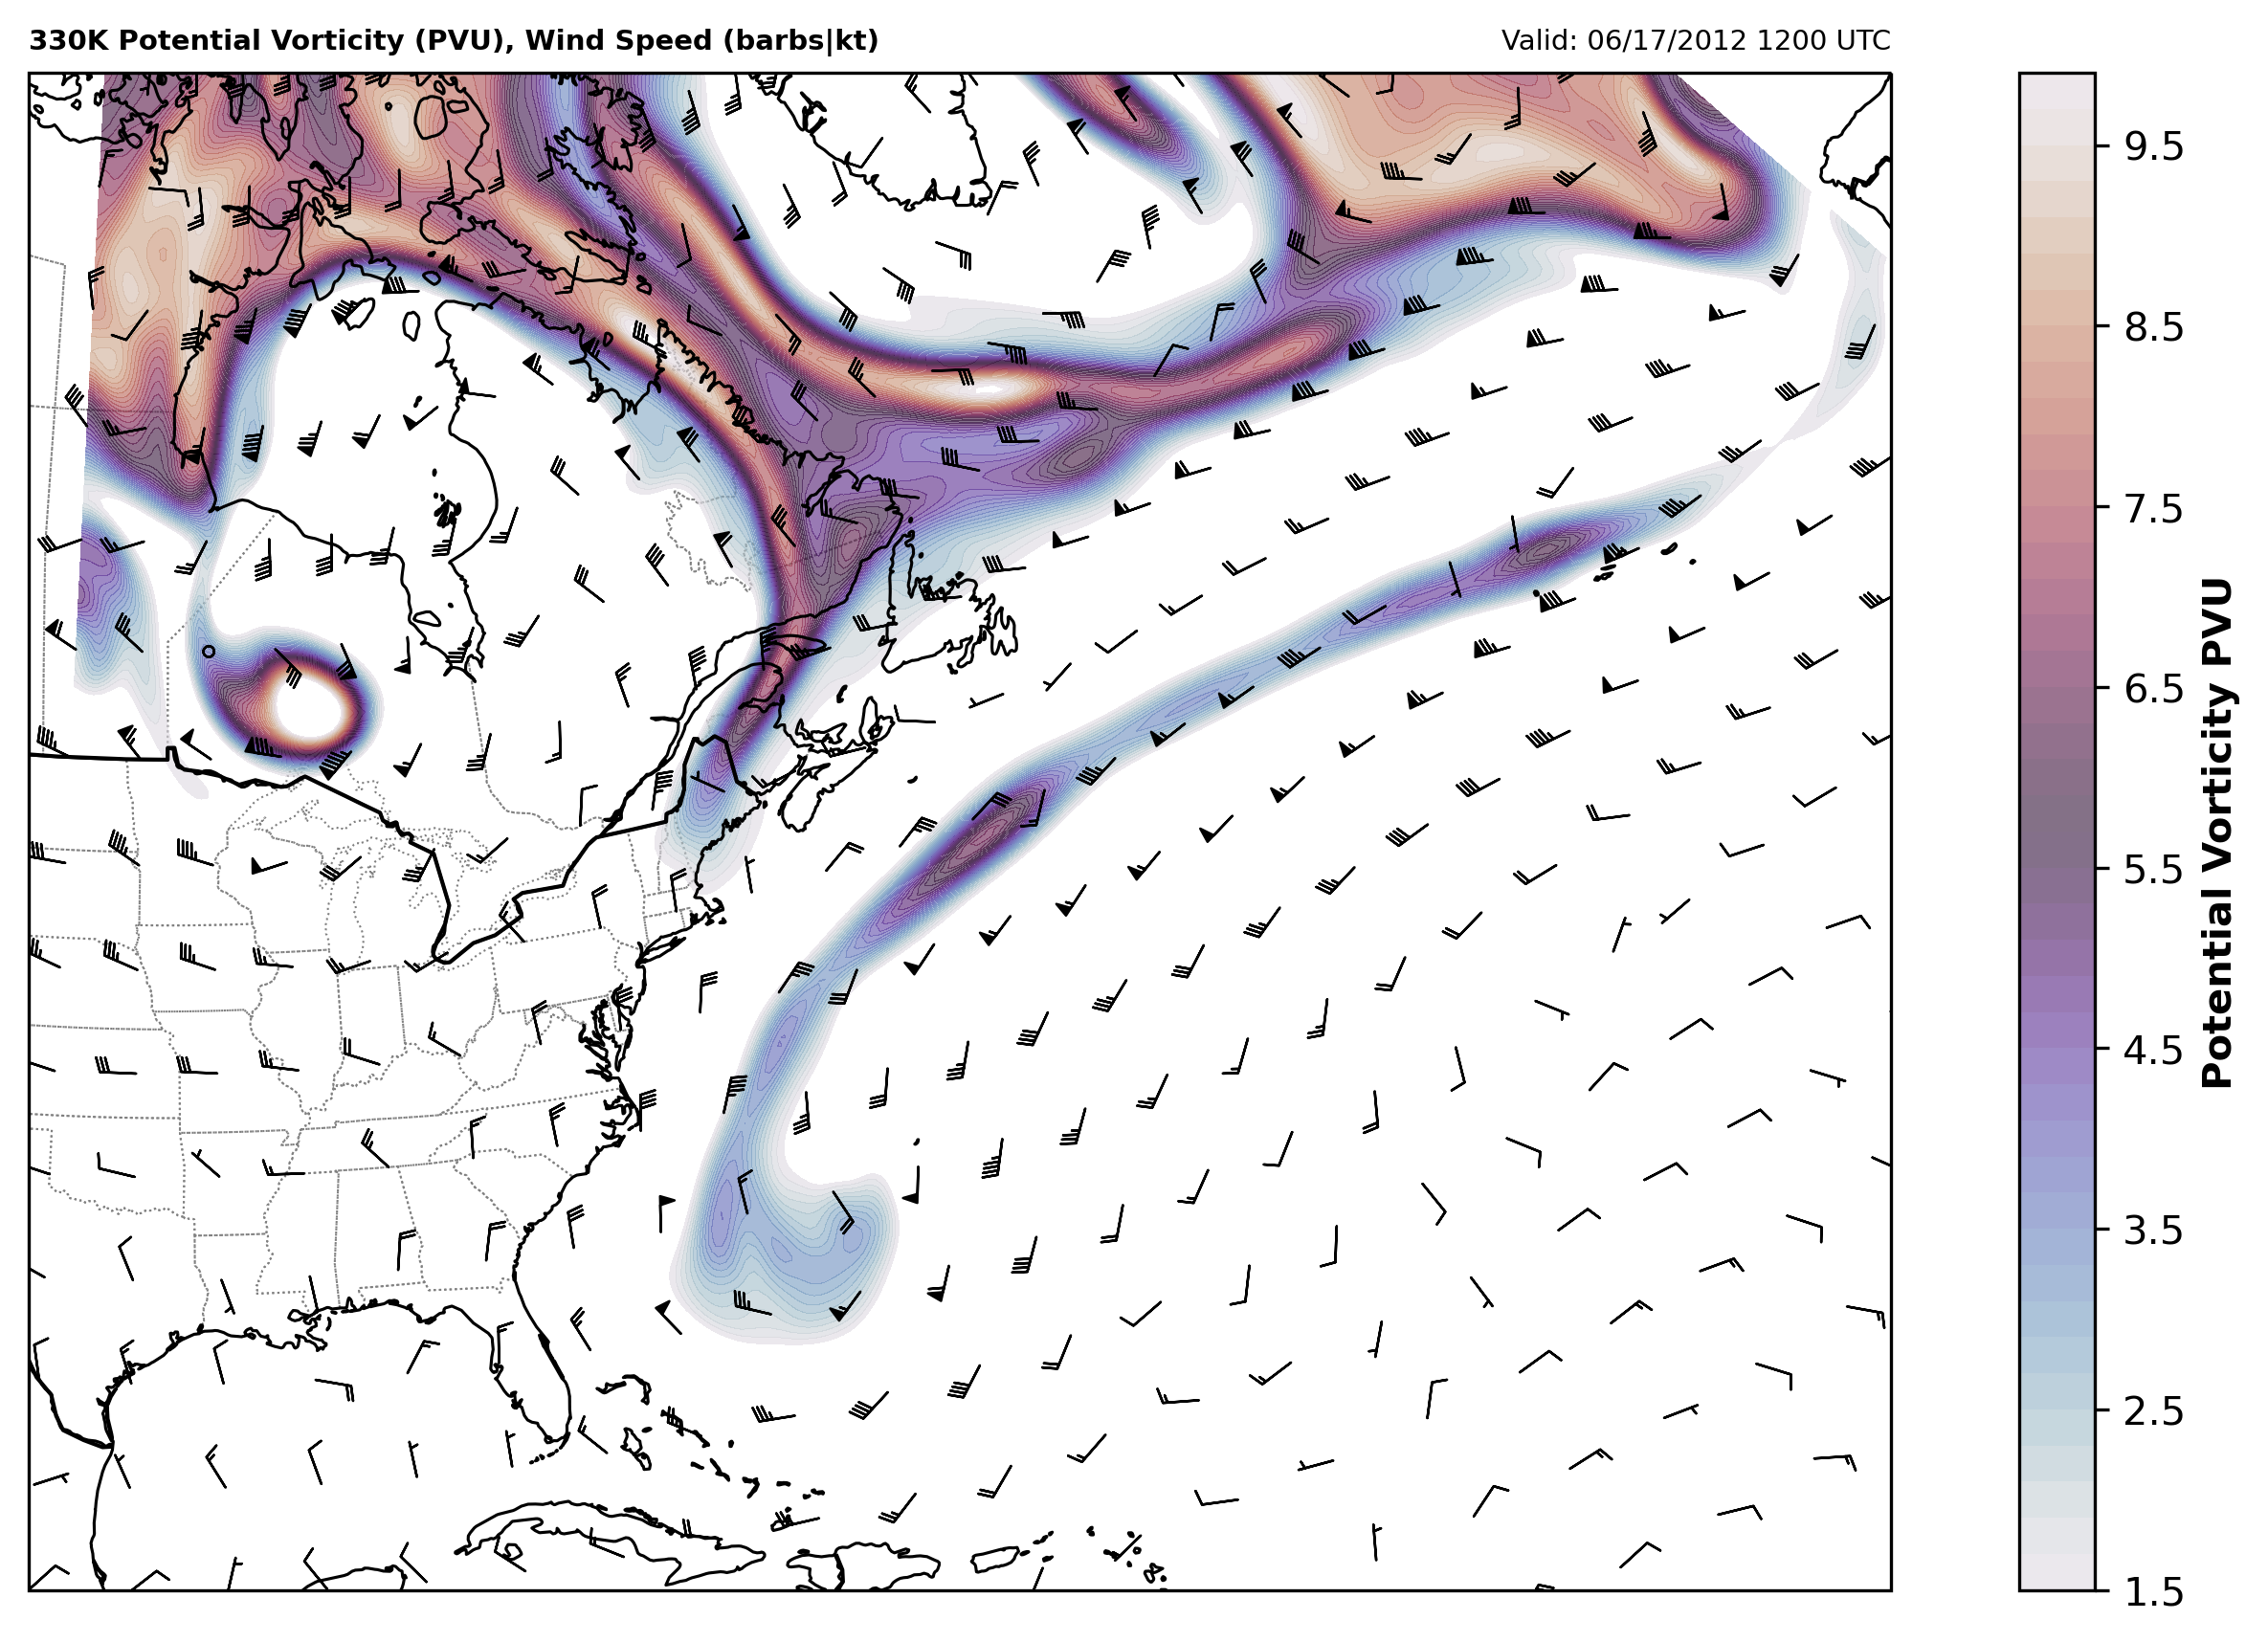

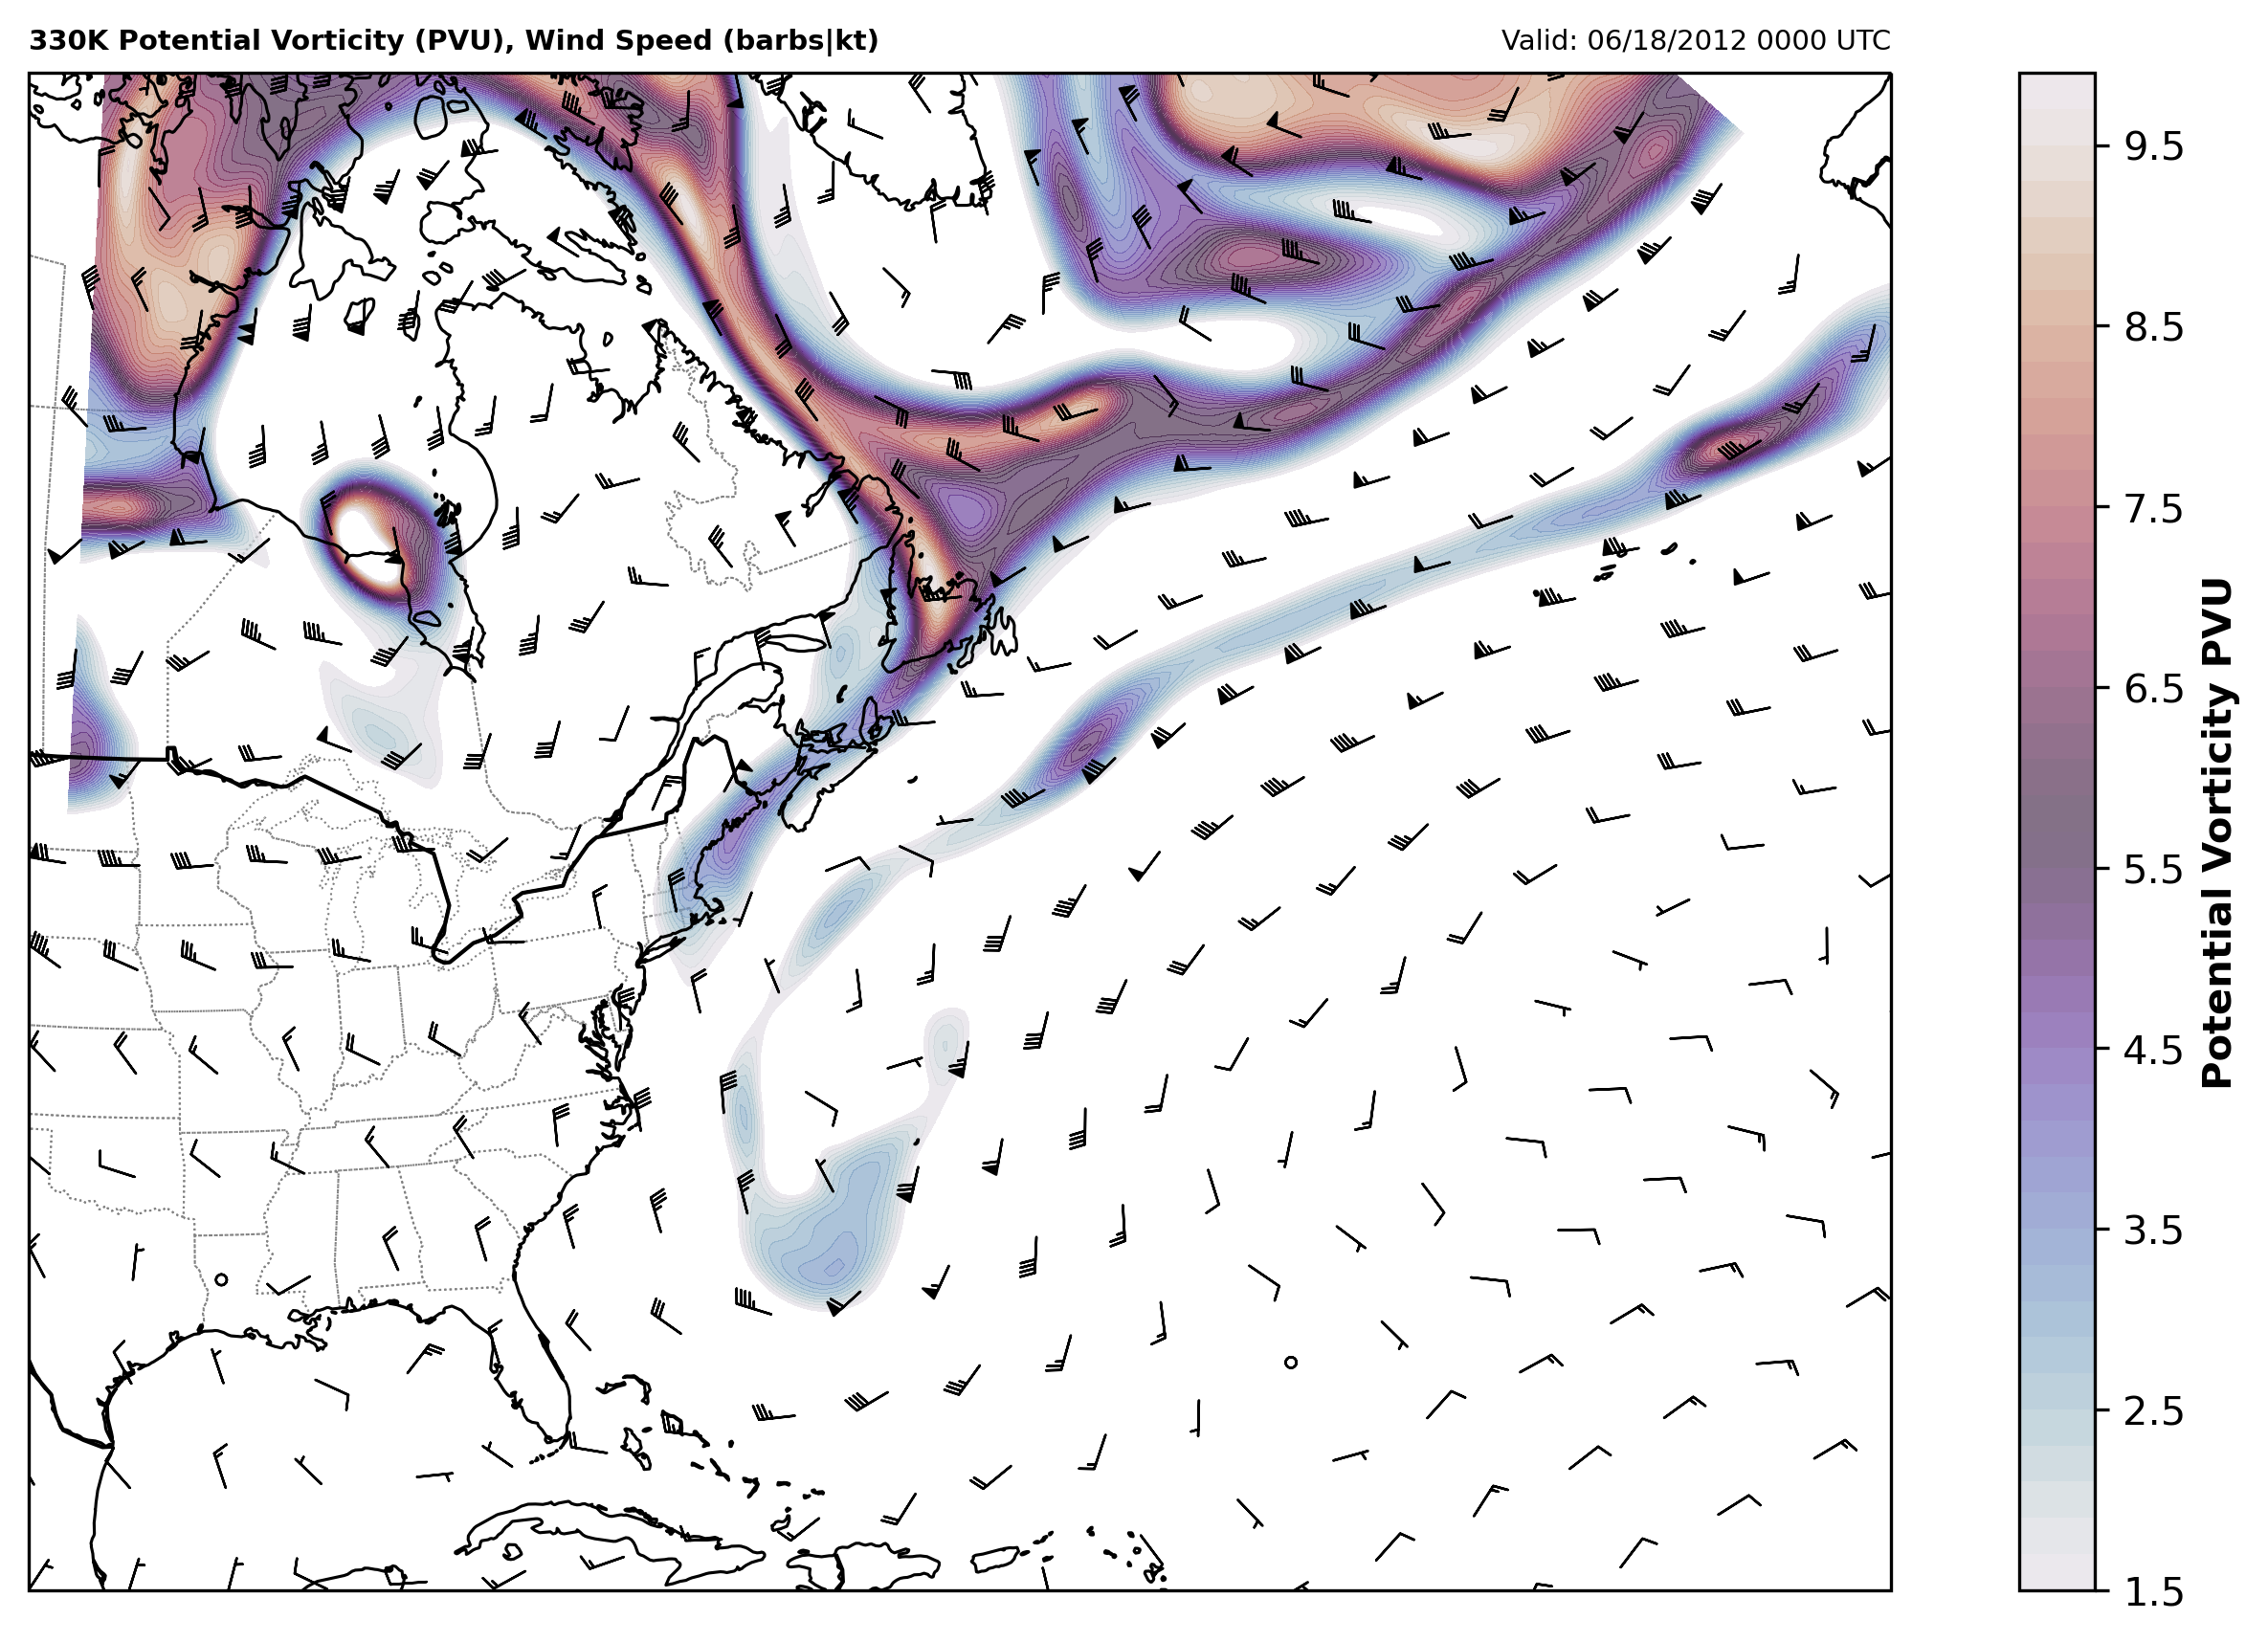

In [6]:
time=datetime(2012,6,17,12)
Kdata=process_K_air_data(time)
plot_330K(time, Kdata)

time=datetime(2012,6,18,0)
Kdata=process_K_air_data(time)
plot_330K(time, Kdata)

In [7]:
Kdata


Magnitude,[[[271.98982962641685 272.13200806804605 272.28628396898455 ... 284.1758356792389 283.5897394660904 282.99651808106455] [272.29924176077833 272.44844299953354 272.6161011126974 ... 283.22030630503235 282.6181757704315 282.04471874660146] [272.73950800911155 272.90804203002625 273.11925375679516 ... 282.25787048304477 281.6954380880352 281.1764129550017] ... [517.7866772034446 518.0220633726786 518.2149724023558 ... 506.66418535630896 507.8755032926771 508.253826538423] [518.2429858584933 518.3838896201568 518.065163860954 ... 504.76342686481433 505.90078716669785 506.85717505028657] [518.8276970129397 518.5262708779362 517.8732578217943 ... 499.75751543322485 501.06787732862796 502.8124999447027]] [[259.59482176752863 259.8137702113376 260.01808665992206 ... 271.2883280759904 270.90743786490737 270.4911421580194] [259.86037958476726 260.0711546502298 260.25647347267454 ... 270.45760134274184 270.0334315583662 269.6079665233739] [260.2677378634658 260.4576607974379 260.64853188011523 ... 269.59843745432977 269.1735890381364 268.7631653761879] ... [462.2100512942896 460.73132421239984 458.6340488877206 ... 442.9817800165861 447.2477799030688 449.1978651505887] [462.5167457304635 460.8024534558868 458.70937012453646 ... 439.6404368830666 442.5143319509816 444.88739215309397] [461.7521715473248 460.16992270461753 458.5604523922051 ... 435.0832238211182 436.42363097331184 438.71280790255156]] [[248.3451342385751 248.56085733749455 248.7540025372666 ... 259.1629954529019 258.966760179587 258.71000136542557] [248.53342365304516 248.73493519973394 248.89364920281545 ... 258.44582988762033 258.18205756304496 257.8902299023098] [248.8338290211058 248.99776044114702 249.13648953106625 ... 257.681029146647 257.380418182299 257.0682684748481] ... [389.69386462918436 389.9249359974726 389.35458432977214 ... 380.87397129043524 384.6856830891256 386.1375347456322] [388.039787826819 388.6663733870821 388.7905516283127 ... 377.3986673083623 378.90902890679837 380.7426427911485] [386.89397976197296 387.6979615977818 388.2116196197489 ... 373.7608836594828 373.4971602666983 375.0382505335007]]]
Units,hectopascal
Magnitude,[[[224.0407302431715 224.07418508321956 224.11047235640345 ... 226.8639046508734 226.7301221584504 226.59451201259273] [224.11351949324418 224.1485979953121 224.18799949948112 ... 226.64569373115307 226.50791704896494 226.37650623577437] [224.21699042266948 224.25656754226392 224.30614209626123 ... 226.42537338763026 226.29637311665232 226.17716547044026] ... [269.2850117314269 269.3199823817113 269.3486338630098 ... 267.61946961134 267.8021185402878 267.85910034751026] [269.35279387981114 269.3737157463929 269.3263844685575 ... 267.33223343740207 267.504200108966 267.64859049178074] [269.4395872326178 269.39485287084943 269.2978760863821 ... 266.5720422647364 266.7715557291126 267.0366114022622]] [[224.47601660918858 224.5300941537971 224.58052842433688 ... 227.31972076441738 227.2284869861778 227.12866775390157] [224.54160188715943 224.59362330317853 224.63933698813813 ... 227.1206205740053 227.0187913425306 226.91653632253983] [224.6421148920499 224.6889387352745 224.73597177163285 ... 226.91424481475764 226.81202033159596 226.71315714433888] ... [264.699892119794 264.45766029167453 264.11314926431373 ... 261.5058023706373 262.2228701164902 262.54903168965757] [264.750062725047 264.4693247509818 264.12554144272667 ... 260.94070678508507 261.4269300665717 261.82672166396003] [264.62494559833135 264.36555108794204 264.1010394436462 ... 260.1650137990692 260.3937674194473 260.78328022471027]] [[225.0109046447157 225.06673132859797 225.1166857521614 ... 227.7687996347184 227.71951089075253 227.6549800418404] [225.059633724355 225.11175547302304 225.15278624079204 ... 227.58853841445662 227.5221487604325 227.44864129834826] [225.13732371360763 225.17969094421017 225.21552920065363 ... 227.3959098714174 227.32008389633717 227.24128041682843] ... [255.92262619514023 255.96597441405356 255.85894505950338 ... 254.25414042567